In [1]:
from load_modules import *
from tensorflow.keras.layers import LeakyReLU
import my_config

import scipy.io as spio
from pathlib import Path

from HSI2RGB import HSI2RGB
import mat73

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for device in physical_devices:
        print("Device:", device)
else:
    print("No GPU devices found.")

# Set GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, False)
    except RuntimeError as e:
        print(e)

# Test for GPU device name
name = tf.test.gpu_device_name()
if name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(name))

# Print the number of available GPUs
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Found GPU at: /device:GPU:0
Num GPUs Available:  1


Load LUT data and find duplicates, select one of each set where the likeleyhood of the parameter values is the greatest

In [3]:
df = pd.read_csv(r"C:\joel_cpp\FullMonte_Spectral\FullMonte\test.csv")

# print(df.head())
headers = df.columns
print(headers)
#max sR 
print(f"max sR = {df['sR'].max()}")
print(f"max sG = {df['sG'].max()}")
print(f"max sB = {df['sB'].max()}")
#count of rows with sR > 255 or sG > 255 or sB > 255
print(f"count of rows with sR > 255 = {len(df[df['sR'] > 255])}")
#length of df
print(f"length of df = {len(df)}")
#remover rows with sR > 255 or sG > 255 or sB > 255
# df = df[df['sR'] <= 255]
# df = df[df['sG'] <= 255]
# df = df[df['sB'] <= 255]
#length of df
print(f"length of df = {len(df)}")
# Cm,Ch,Bm,Bh,T,400,413.33,426.67,440,453.33,466.67,480,493.33,506.67,520,533.33,546.67,560,573.33,586.67,600,613.33,626.67,640,653.33,666.67,680,693.33,706.67,720,733.33,746.67,760,773.33,786.67,800,sR,sG,sB
x = df[headers[5:-3]].to_numpy(dtype='float32')
print(headers[5:-3])
#select 31 wavelengths

#print wavelengths
print(x[0])train_autoencoder_spectral.ipynb
y = df[['Cm', 'Ch', 'Bm', 'Bh','T']].to_numpy(dtype='float32')
ENCODER_INPUT_DIM = DECODER_OUTPUT_DIM = x.shape[1]
print(f"x shape {x.shape}")
#reshape x to 2D array
x = x.reshape(-1, x.shape[1])
print(f"x shape {x.shape}")
y = y.reshape(-1, y.shape[1])
print(f"y shape {y.shape}")
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)
# #remove any header values
x_train = x_train[1:]
x_test = x_test[1:]
y_train = y_train[1:]
y_test = y_test[1:]



C_m = sorted(df['Cm'].unique())
C_h = sorted(df['Ch'].unique())
B_m = sorted(df['Bm'].unique())
B_h = sorted(df['Bh'].unique())
T = sorted(df['T'].unique())
print(f"Cm = {C_m}")
print(f"Ch = {C_h}")
print(f"Bm = {B_m}")
print(f"Bh = {B_h}")
print(f"T = {T}")


SyntaxError: invalid syntax (4211144266.py, line 26)

In [ ]:
np.random.seed(7)
BATCH_SIZE = 2048
NUM_NEURONS = 75
NUM_LAYERS = 2
NUM_EPOCHS = 200
LR = 1e-3
MLR = 1e-6
about_string = f"batch_size_{BATCH_SIZE}_neurons_{NUM_NEURONS}_layers_{NUM_LAYERS}_epochs_{NUM_EPOCHS}_lr_{LR}_mlr_{MLR}"
upper_bounds = [0.5, 0.32, 1, 1,0.25]
lower_bounds = [0.001, 0.001, 0, 0,0.01]
def decoder():
    input = Input(shape=(5,), name="decoder_input")
    for i in range(NUM_LAYERS):
        if i == 0:
            x = Dense(NUM_NEURONS, activation='relu', name=f"decoder_dense_{i+1}")(input)
        else:
            x = Dense(NUM_NEURONS, activation='relu', name=f"decoder_dense_{i+1}")(x)
    out = Dense(DECODER_OUTPUT_DIM, name="encoder_output")(x)
    #leaky relu activation=LeakyReLU(alpha=0.3)
    model = Model(inputs=input, outputs=out, name='decoder')
    return model

def encoder():
    input = Input(shape=(ENCODER_INPUT_DIM,),name="encoder_input")
    for i in range(NUM_LAYERS):
        if i == 0:
            x = Dense(NUM_NEURONS, activation='relu', name=f"encoder_dense_{i+1}")(input)
        else:
            x = Dense(NUM_NEURONS, activation='relu', name=f"encoder_dense_{i+1}")(x)
    out = Dense(5, name="decoder_output")(x)
    model = Model(inputs=input, outputs=out, name = 'encoder')
    return model
def autoencoder(encoder, decoder):
    input_end_to_end = Input(shape=(ENCODER_INPUT_DIM,))
    l1 = encoder(input_end_to_end)
    l2 = decoder(l1)
    input_list = [encoder.input, decoder.input, input_end_to_end]
    output_list = [encoder.output, decoder.output, l2]
    model = Model(inputs=input_list, outputs=output_list, name = 'autoencoder')
    return model

encoder = encoder()
decoder = decoder()
autoencoder = autoencoder(encoder, decoder)
print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())

def albedo_loss(y_true, y_pred):
    #l1 norm
    l1_norm = K.sum(K.abs(y_pred - y_true), axis=-1)
    return l1_norm

def parameter_loss(y_true, y_pred):
    #l2 norm
    l2_norm = K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))
    lower_bound_mask = tf.math.less(y_pred, lower_bounds)
    upper_bound_mask = tf.math.greater(y_pred, upper_bounds)
    out_of_range_mask = tf.logical_or(lower_bound_mask, upper_bound_mask)
    # Apply a penalty for out of range values)
    out_of_range_penalty = tf.reduce_sum(tf.cast(out_of_range_mask, tf.float32))/BATCH_SIZE
    return l2_norm 
    
def end_to_end_loss(y_true, y_pred):
    #l1 norm
    l1_norm = K.sum(K.abs(y_pred - y_true), axis=-1)
    return l1_norm

autoencoder.compile(optimizer='adam', loss=[parameter_loss, albedo_loss, end_to_end_loss], loss_weights= [0.8, 0.1, 0.1])
# loss_weights = [0.3, 0.1, 0.6]
# loss_weights2 = [0.2, 0.2, 0.6]



Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 39)]              0         
                                                                 
 encoder_dense_1 (Dense)     (None, 75)                3000      
                                                                 
 encoder_dense_2 (Dense)     (None, 75)                5700      
                                                                 
 decoder_output (Dense)      (None, 5)                 380       
                                                                 
Total params: 9,080
Trainable params: 9,080
Non-trainable params: 0
_________________________________________________________________
None
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None

In [ ]:
checkpoint = ModelCheckpoint(r"C:\Users\joeli\OneDrive\Documents\GitHub\AutoEncoder_Integrated\autoencoder_best.h5py", monitor='loss', verbose=0,
    save_best_only=True, mode='auto', period=200)
adjust_lr = ReduceLROnPlateau(monitor='loss', factor=0.01, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=MLR, lr=LR)
# Define the Keras TensorBoard callback.

logdir=r"C:\Users\joeli\OneDrive\Documents\GitHub\AutoEncoder_Integrated\tensorboard_log_dir"
# tensorboard_callback = tf.keras.callbacks.TensorBoard(filepath=logdir, save_weights_only = True,save_freq = 100,verbose = 1)
print_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: print(f"epoch: {epoch} , {logs}") if epoch % 10 == 0 else None)
#stop training if loss does not improve after 7 epochs
early_stopping = EarlyStopping(monitor='loss', min_delta=0.0001, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
#min delta is the minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
callbacks = [
    checkpoint,
    adjust_lr,
    print_callback,
    early_stopping
]
with tf.device('/device:GPU:0') as device:
    #show device name
    print(device)
    #ae_in: enc_in, dec_in, end_to_end_in
    x = [x_train, y_train,x_train]
     #ae_out: enc_out, dec_out, end_to_end_out
    x_val = [x_test, y_test,x_test]
    #outputs: encoder, decoder, autoencoder
    y = [y_train,x_train,x_train]
    y_val = [y_test,x_test,x_test]
    autoencoder.fit(x,y, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, shuffle=True, validation_data=(x_val, y_val), callbacks=callbacks,verbose=0)

       

None
epoch: 0 , {'loss': 2.110163688659668, 'decoder_output_loss': 0.7485477328300476, 'encoder_output_loss': 8.248682022094727, 'decoder_loss': 6.864571571350098, 'val_loss': 1.6285066604614258, 'val_decoder_output_loss': 0.6833491921424866, 'val_encoder_output_loss': 7.147830963134766, 'val_decoder_loss': 3.670440435409546, 'lr': 0.001}
epoch: 10 , {'loss': 0.6869935393333435, 'decoder_output_loss': 0.41857290267944336, 'encoder_output_loss': 2.696084976196289, 'decoder_loss': 0.8252664804458618, 'val_loss': 0.6697953939437866, 'val_decoder_output_loss': 0.41567590832710266, 'val_encoder_output_loss': 2.6068782806396484, 'val_decoder_loss': 0.7656685709953308, 'lr': 0.001}
epoch: 20 , {'loss': 0.5779243111610413, 'decoder_output_loss': 0.4027157127857208, 'encoder_output_loss': 1.7751950025558472, 'decoder_loss': 0.7823215126991272, 'val_loss': 0.5790369510650635, 'val_decoder_output_loss': 0.4007989466190338, 'val_encoder_output_loss': 1.7481012344360352, 'val_decoder_loss': 0.83587

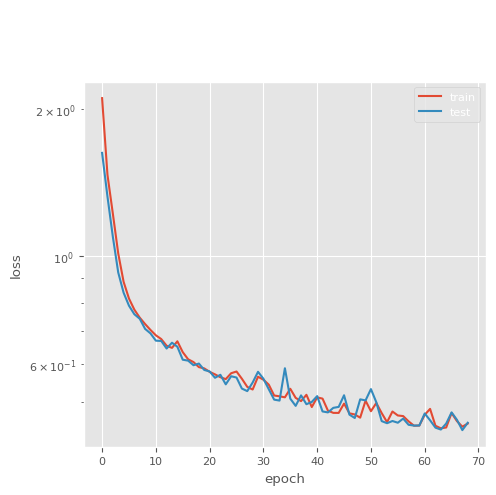

In [ ]:
# # Plot the loss function
#dark background
plt.style.use('dark_background')
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
#add tick labels
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
#ggplot style
plt.style.use('ggplot')
plt.figure(figsize=(5,5))
#fontsize 16
plt.rcParams.update({'font.size': 8})
plt.plot(autoencoder.history.history['loss']) 
plt.plot(autoencoder.history.history['val_loss'])
plt.title('model loss \n = encoder loss (L1 norm) + \n decoder loss (L2 norm) +\n end to end loss (L1 norm) ')
plt.ylabel('loss')
plt.yscale('log')
plt.xlabel('epoch')
plt.yticks
# plt.xlim(-1,50)
plt.tight_layout()
plt.legend(['train', 'test'], loc='upper right')
#show tick labels
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.show()




In [ ]:
WIDTH = HEIGHT = 1024

def encode(img):
    hsi_cube = np.asarray(img).reshape(-1,ENCODER_INPUT_DIM).astype('float32')
    # pred_maps = encoder.predict(hsi_cube)
    start = time.time()
    with tf.device('/device:GPU:0') as device:
        pred_maps = encoder.predict_on_batch(hsi_cube)
    end = time.time()
    elapsed = end - start
    return pred_maps, elapsed
 
def decode(encoded):
    # recovered = decoder.predict(encoded)
    start = time.time()
    with tf.device('/device:GPU:0') as device:
        #lower batch size to 2048
        recovered = decoder.predict_on_batch(encoded)
        # recovered = decoder.predict_on_batch(encoded)
    end = time.time()
    elapsed = end - start
    recovered = np.clip(recovered, 0, 1)
    
    return recovered, elapsed


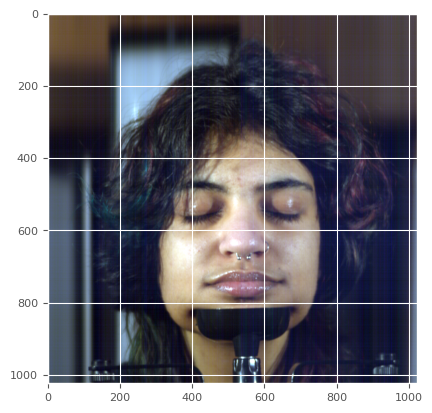

hsi_data shape (1024, 1024, 39)


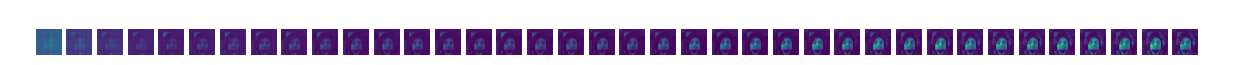

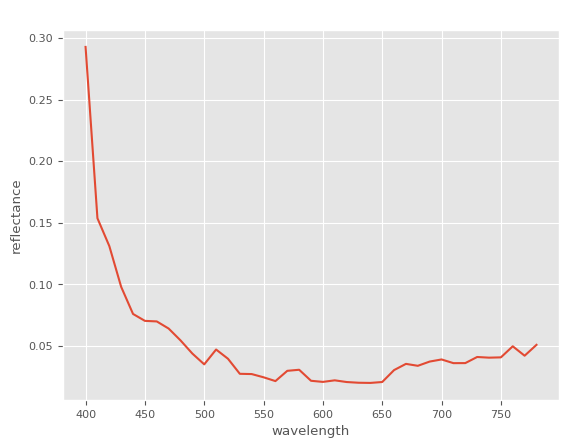

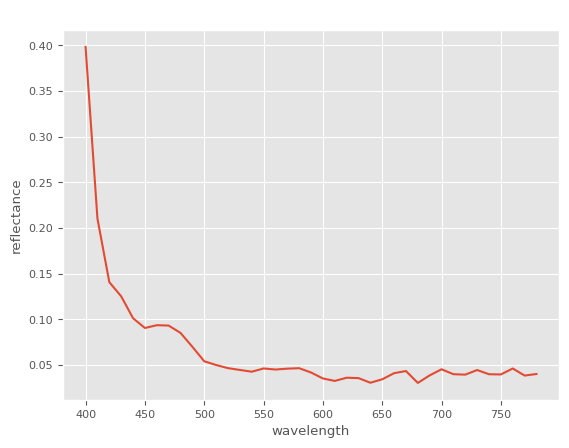

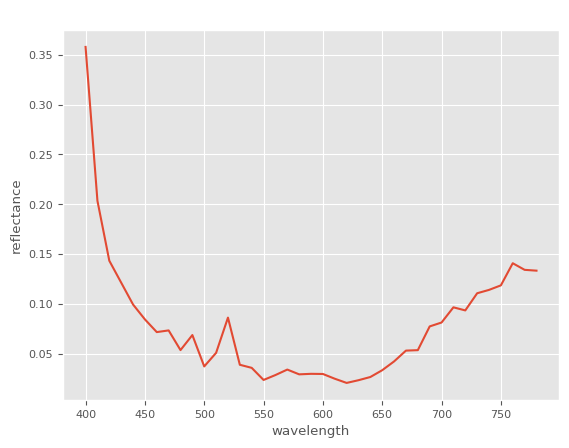

encoded shape (1048576, 5)


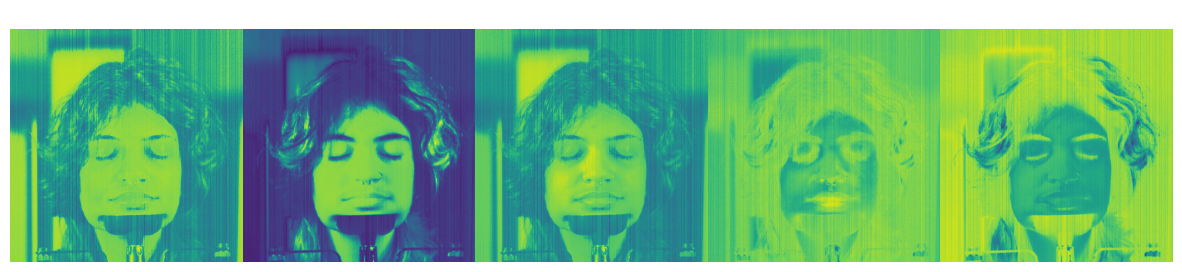

recovered shape (1048576, 39)


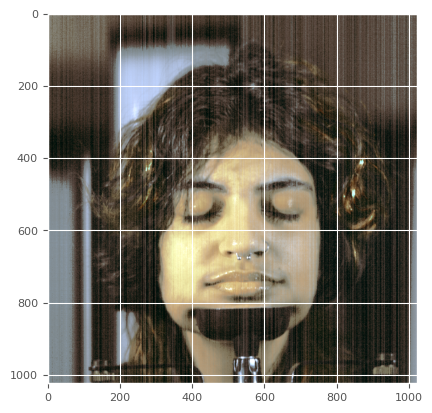

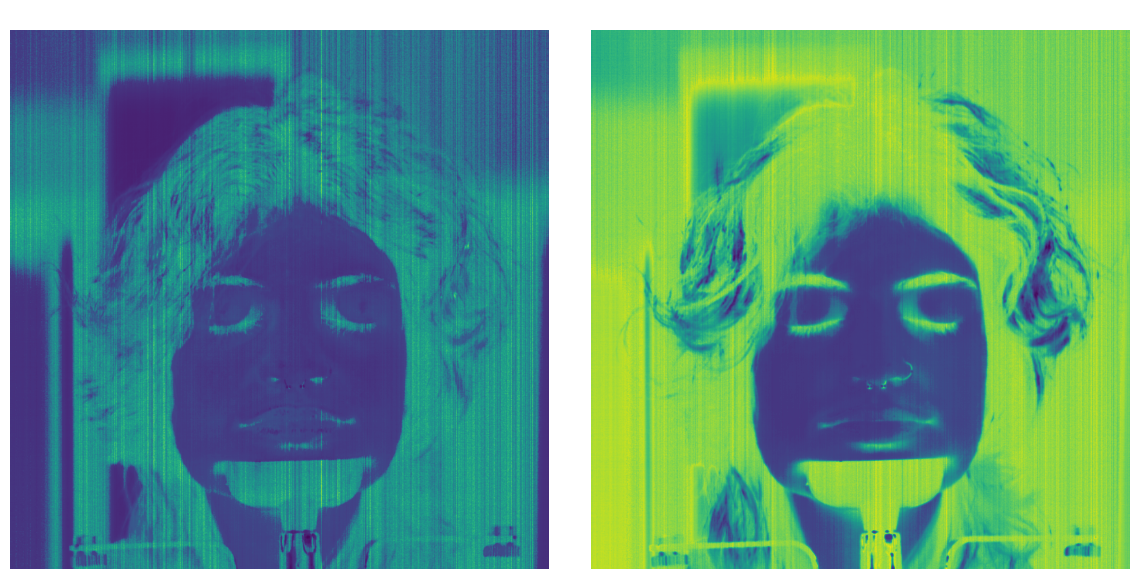

Cm min -0.044348061084747314 mean 0.12908825278282166 max 0.430530309677124
Ch min -0.09800776839256287 mean 0.3142373859882355 max 0.5174385905265808
Bm min 0.15212997794151306 mean 1.3642326593399048 max 3.1895289421081543
Bh min -0.14263097941875458 mean 0.13086020946502686 max 0.9853367209434509
T min 0.10851508378982544 mean 0.1987147182226181 max 0.5084198117256165


In [ ]:
import time
import numpy as np
import mat73
import matplotlib.pyplot as plt
import cv2

# Constants
WIDTH = HEIGHT = 1024
wl_vis = np.linspace(400,700, 31)
wl_nir = np.linspace(710, 780, 8)
wavelengths = np.concatenate([wl_vis, wl_nir])

# Load data
vis_path = r"D:\HSI_DATASET\train_vis\VIS\p006_neutral_front.mat"
nir_path = r"D:\hsi\Hyper-Skin(MSI,NIR)\train\NIR\p006_neutral_front.mat"
rgb_path = r"D:\HSI_DATASET\train_vis\RGB\p006_neutral_front.mat"
vis_data = mat73.loadmat(vis_path)
nir_data = mat73.loadmat(nir_path)
# Print shapes
vis_data = vis_data['cube']
nir_data = nir_data['cube']

# Convert VIS data to RGB and display
vis_data_flat = np.reshape(vis_data, [-1, vis_data.shape[2]])
illuminant = 65
threshold = 0.002
rgb_image = HSI2RGB(wl_vis, vis_data_flat, vis_data.shape[1], vis_data.shape[0], illuminant, threshold)
plt.imshow(rgb_image)
plt.show()

# Stack VIS and NIR data
nir_data_selected = nir_data[:,:,1:9]
hsi_data = np.dstack((vis_data, nir_data_selected))
print(f"hsi_data shape {hsi_data.shape}")

# Display spectral bands as subplots
fig, axs = plt.subplots(nrows=1, ncols=len(wavelengths)-1, figsize=(15,7))
for idx, wl in enumerate(wavelengths[:-1]):
    axs[idx].imshow(hsi_data[:,:,idx], cmap='viridis')
    axs[idx].set_title(f"{wl} nm")
    axs[idx].axis('off')
plt.show()

# Reflectance vs wavelength plot for 3 random pixels
rand_x = np.random.randint(5, hsi_data.shape[1], 3)
rand_y = np.random.randint(5, hsi_data.shape[0], 3)
for x, y in zip(rand_x, rand_y):
    plt.plot(wavelengths, hsi_data[y, x, :])
    plt.ylabel('reflectance')
    plt.xlabel('wavelength')
    plt.title(f"pixel ({x},{y})")
    plt.show()

# Resize HSI data
hsi_data_resized = cv2.resize(hsi_data, (WIDTH, HEIGHT), interpolation=cv2.INTER_AREA)

# Encode and decode the HSI cube
encoded, elapsed = encode(hsi_data_resized)
print(f"encoded shape {encoded.shape}")

# Display parameter maps
headers = ["Header1", "Header2", "Header3", "Header4", "Header5"]  # Replace with actual headers
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15,7))
fig.subplots_adjust(wspace=0)
for i, ax in enumerate(axs):
    ax.imshow(encoded[:, i].reshape((WIDTH,HEIGHT)), cmap='viridis_r')
    ax.set_title(headers[i])
    ax.axis('off')
plt.show()

# Decode and display recovered image
recovered, elapsed = decode(encoded)
print(f"recovered shape {recovered.shape}")
recovered_rgb = HSI2RGB(wl_vis, recovered[:,:31], WIDTH, HEIGHT, illuminant, threshold)
plt.imshow(recovered_rgb)
plt.show()

# Display Cm and Ch
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
fig.subplots_adjust(wspace=0)
axs[0].imshow(encoded[:,0].reshape(WIDTH,HEIGHT), cmap='viridis', vmin=np.min(encoded[:,0]), vmax=np.max(encoded[:,0]))
axs[0].set_title('Cm')
axs[1].imshow(encoded[:,1].reshape(WIDTH,HEIGHT), cmap='viridis', vmin=np.min(encoded[:,1]), vmax=np.max(encoded[:,1]))
axs[1].set_title('Ch')
for ax in axs:
    ax.axis('off')
plt.show()

# Stats
encoded_reshaped = encoded.reshape((WIDTH, HEIGHT, 5))
params = ["Cm", "Ch", "Bm", "Bh", "T"]
for i, param in enumerate(params):
    print(f"{param} min {np.min(encoded_reshaped[:,:,i])} mean {np.mean(encoded_reshaped[:,:,i])} max {np.max(encoded_reshaped[:,:,i])}")

In [ ]:
import numpy as np
import pandas as pd
WIDTH = HEIGHT = 25
# Load the LUT from the CSV
lut_df = df
#only even rows
lut_df = lut_df.iloc[::8]

# Extract the spectral data from the LUT dataframe
spectral_data = lut_df.iloc[:, 5:-3].values.T  # Transpose for compatibility with lstsq
print(f"Original spectral_data shape: {spectral_data.shape}")

# Assuming hsi_data is already loaded
# Let's crop the central 200x200 pixels
center_x, center_y = hsi_data.shape[0] // 2, hsi_data.shape[1] // 2
hsi_crop = hsi_data[center_x-50:center_x, center_y-25:center_y+25, :]
print(f"hsi_crop shape: {hsi_crop.shape}")

# Extract parameters from the LUT dataframe
parameters = lut_df.iloc[:, 0:5].values
print(f"parameters shape: {parameters.shape}")

# Ensure that the number of spectral points matches the third dimension of the HSI cube
assert spectral_data.shape[0] == hsi_crop.shape[2], "Mismatched spectral dimension between LUT and HSI cube."

# Initialize an array to store the coefficients for each pixel
coefficients = np.zeros((25, 25, parameters.shape[1]))

# Loop over each pixel in the cropped HSI and find the least squares fit
for i in range(25):
    for j in range(25):
        pixel_spectrum = hsi_crop[i, j, :]
        # Least squares fit
        coeffs, _, _, _ = np.linalg.lstsq(spectral_data, pixel_spectrum, rcond=None)
        coefficients[i, j] = coeffs[:parameters.shape[1]]  # only take the coefficients for parameters

# Save the coefficients for each pixel
np.save("coefficients.npy", coefficients)
hsi_crop = cv2.resize(hsi_crop, (WIDTH, HEIGHT), interpolation=cv2.INTER_AREA)
#plot the 10 by 10 pixel images in rgb using HSI2RGB
rgb = HSI2RGB(wavelengths, hsi_crop.reshape(-1, hsi_crop.shape[2]), 25, 25, illuminant, threshold)
plt.imshow(rgb)
plt.show()
#plot the Cm, Ch, Bm, Bh, T maps from the coefficients
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15,7))
fig.subplots_adjust(wspace=0)
axs[0].imshow(coefficients[:,:,0], cmap='viridis')
axs[0].set_title('Cm')
axs[1].imshow(coefficients[:,:,1], cmap='viridis')
axs[1].set_title('Ch')
axs[2].imshow(coefficients[:,:,2], cmap='viridis')
axs[2].set_title('Bm')
axs[3].imshow(coefficients[:,:,3], cmap='viridis')
axs[3].set_title('Bh')
axs[4].imshow(coefficients[:,:,4], cmap='viridis')
axs[4].set_title('T')
for ax in axs:
    ax.axis('off')
plt.show()


Original spectral_data shape: (39, 7382)
hsi_crop shape: (50, 50, 31)
parameters shape: (7382, 5)


AssertionError: Mismatched spectral dimension between LUT and HSI cube.

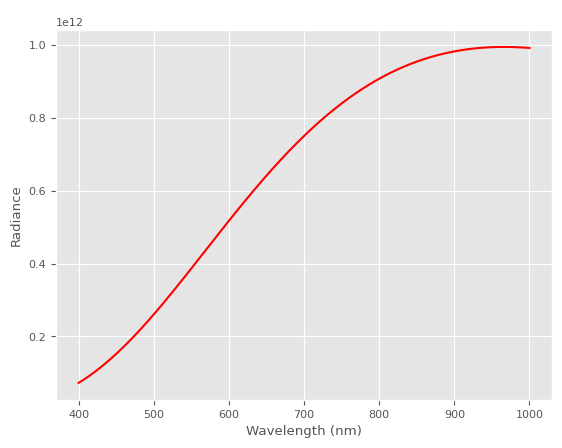

In [ ]:
#load spectral data for tungsten halogen from scipy
from scipy.interpolate import interp1d
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import Planck, h, c, Boltzmann, pi
from scipy.special import expn

def blackbody_lambda(wavelength, temperature):
    """ Blackbody as a function of wavelength (lambda) and temperature T.
    """
    factor = (2 * h * c ** 2) / (wavelength ** 5)
    exponential_factor = h * c / (wavelength * Boltzmann * temperature)
    radiance = factor * 1.0 / (np.exp(exponential_factor) - 1)
    return radiance

# Define a range of wavelengths (e.g., 400nm to 1000nm, which roughly corresponds to visible to near-infrared)
wavelengths = np.linspace(400e-9, 1000e-9, 1000)  # in meters

# Compute the radiance for a temperature of 3000K (common for halogen bulbs)
temperature = 3000
radiance = blackbody_lambda(wavelengths, temperature)

# Plot the computed spectrum
plt.plot(wavelengths * 1e9, radiance, 'r-')  # Convert wavelengths to nm for the plot
plt.title(f"Blackbody Radiation at {temperature}K")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Radiance")
plt.grid(True)
plt.show()


(31,)


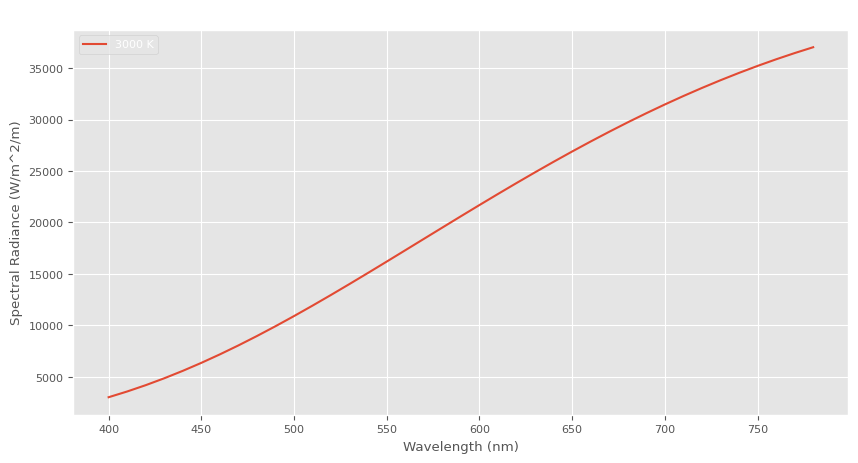

shape of wavelengths (31,)
shape of radiance (39,)
(1024, 1024, 31)
(31,)
1.1631279027316294e+51
0.009674591927848758
0.11857788583030912
1.162616119309106


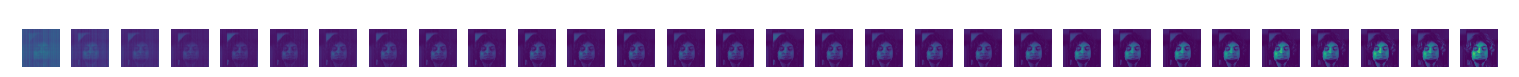

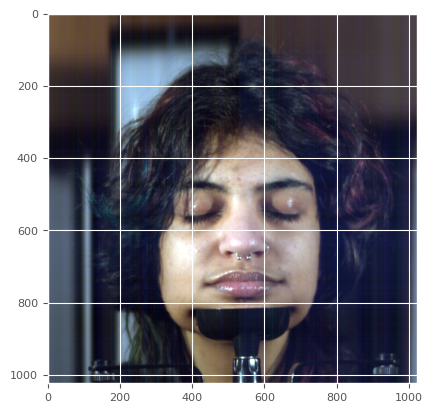

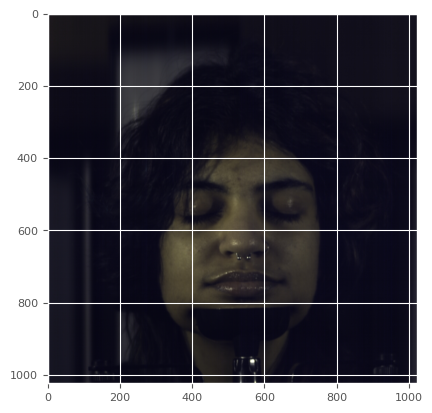

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import h, c, k
vis_path = r"D:\HSI_DATASET\train_vis\VIS\p006_neutral_front.mat"
nir_path = r"D:\hsi\Hyper-Skin(MSI,NIR)\train\NIR\p006_neutral_front.mat"
rgb_path = r"D:\HSI_DATASET\train_vis\RGB\p006_neutral_front.mat"
rgb_n_f = plt.imread(r"D:\HSI_DATASET\train_vis\RGB_CIE\p006_neutral_front.jpg")
rgb_n_l = plt.imread(r"D:\HSI_DATASET\train_vis\RGB_CIE\p006_neutral_left.jpg")
rgb_n_r = plt.imread(r"D:\HSI_DATASET\train_vis\RGB_CIE\p006_neutral_right.jpg")
def planck(wavelength, temperature):
    """Calculate the spectral radiance of a blackbody using Planck's law."""
    return (8 * np.pi * h * c) / (wavelength**5 * (np.exp((h * c) / (wavelength * k * temperature)) - 1))

# Convert nanometers to meters
wavelengths_meters = np.arange(400e-9, 790e-9, 10e-9)
wavelengths_nm = np.arange(400, 790, 10)[:31]
print(wavelengths_nm.shape)
# Temperatures in Kelvin
temperatures = [3000]

# Plot the blackbody spectra
plt.figure(figsize=(10, 5))
for temp in temperatures:
    radiance = planck(wavelengths_meters, temp)
    plt.plot(wavelengths_meters * 1e9, radiance, label=f'{temp} K')

plt.xlabel('Wavelength (nm)')
plt.ylabel('Spectral Radiance (W/m^2/m)')
plt.title('Blackbody Spectral Distribution')
plt.legend()
plt.grid(True)
plt.show()
print(f"shape of wavelengths {wavelengths.shape}")
print(f"shape of radiance {radiance.shape}")
#get the first 39 values of radiance
radiance = radiance[:31]/np.max(radiance[:31])
wavelengths = wavelengths[:31]
blackbody_contrib = blackbody_contrib[:31]
print(hsi_data.shape)  # Should print (1024,1024,39)
print(blackbody_contrib.shape)  # Should now print (39,)

# Ensure that there are no overflows by checking the maximum value
print(np.max(blackbody_contrib))

# Remove the blackbody contribution
# hsi_data_corrected = hsi_data - blackbody_contrib[np.newaxis, np.newaxis, :]
#for each of the 1024 by 1024 pixels, subtract the blackbody contribution

#max value of hsi_data_corrected 
max_hsi = np.max(hsi_data_corrected)
# for i in range(1024):
#     for j in range(1024):
#         for k in range(31):
#             if hsi_data[i,j,k] > blackbody_contrib[k]*0.21:
#                 hsi_data_corrected[i,j,k] = hsi_data[i,j,k] - blackbody_contrib[k]*0.21
#             else:
#                 hsi_data_corrected[i,j,k] = hsi_data[i,j,k]
# Normalize the blackbody_contrib for dot product
#first 31 bands

hsi_data = hsi_data[:,:,:31] 
blackbody_contrib = blackbody_contrib[:31]
blackbody_normalized = blackbody_contrib / np.linalg.norm(blackbody_contrib)

# Determine the scaling factors
scaling_factors = np.einsum('ijk,k->ij', hsi_data, blackbody_normalized)

# Scale the blackbody contribution for each pixel
scaled_blackbody = scaling_factors[:, :, np.newaxis] * blackbody_normalized


# Subtract the scaled blackbody contribution from the original data
hsi_data_corrected = hsi_data + (0.1 * scaled_blackbody)


#min mean max
print(np.min(hsi_data_corrected))
print(np.mean(hsi_data_corrected))
print(np.max(hsi_data_corrected))

# Display the corrected spectral bands as subplots
fig, axs = plt.subplots(nrows=1, ncols=len(wavelengths_nm)-1, figsize=(15,7))
for idx, wl in enumerate(wavelengths_nm[:-1]):
    axs[idx].imshow(hsi_data_corrected[:,:,idx], cmap='viridis')
    axs[idx].set_title(f"{wl} nm")
    axs[idx].axis('off')
plt.tight_layout()
plt.show()
#first 31 bands
hsi_data_corrected_flat = np.reshape(hsi_data_corrected, [-1, hsi_data_corrected.shape[2]])[:,:31]

illuminant = 65
threshold = 0.002

rgb_image = HSI2RGB(wavelengths_nm, hsi_data_corrected_flat, 1024, 1024, illuminant, threshold)
plt.imshow(rgb_image)
plt.show()
#plot original image
plt.imshow(plt.imread(r"D:\HSI_DATASET\train_vis\RGB_CIE\p006_neutral_front.jpg"))
plt.show()